

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [27]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['cats', 'dogs']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':20},
        'lenet':{'dropout':0.2, 'epochs':20},
        'custom':{'dropout':0.2, 'epochs':20},
        'vgg':{'dropout':0.4, 'epochs':20},
        'resnet':{'epochs':20}           
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-16 03:01:49,584: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json


In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
!ls -l $train_dir
!ls -l $train_dir/cats | wc -l
!ls -l $train_dir/dogs | wc -l
!ls -l $train_dir/cats | head -5

!ls -l $validation_dir/cats | wc -l 
!ls -l $validation_dir/dogs | wc -l

total 84
drwxr-xr-x. 2 root root 24576 Aug 10 10:59 cats
drwxr-xr-x. 2 root root 24576 Aug 10 10:59 dogs
1001
1001
total 22644
-rw-r--r--. 1 root root 12414 Aug 16 02:57 cat.0.jpg
-rw-r--r--. 1 root root 16880 Aug 16 02:57 cat.1.jpg
-rw-r--r--. 1 root root 34315 Aug 16 02:57 cat.10.jpg
-rw-r--r--. 1 root root 28377 Aug 16 02:57 cat.100.jpg
ls: write error: Broken pipe
501
501


In [8]:
def image_to_array(img_file):
    img = load_img(img_file) 
    img = img.resize((160, 160))
    x = img_to_array(img) 
    return x

def images_to_array(image_folder):
    files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    x = np.array([image_to_array(file) for file in files])
    return x 

def load_image_folder(image_folder, classes):
    x = None
    y = None
    for i, class_ in enumerate(classes):
        folder = os.path.join(image_folder, class_) 
        x_ = images_to_array(folder)
        y_ = [i]*len(x_)
        if x is None:
            x = x_
            y = y_
        else:
            x = np.concatenate([x, x_])
            y = np.concatenate([y, y_])
        
    return x, y

train_images, train_labels = load_image_folder(train_dir, params.classes)
print(train_images.shape, train_labels.shape)

test_images, test_labels = load_image_folder(validation_dir, params.classes)
print(test_images.shape, test_labels.shape)

(2000, 160, 160, 3) (2000,)
(1000, 160, 160, 3) (1000,)


In [9]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [10]:
Counter(train_labels)

Counter({0: 1000, 1: 1000})



### Data Explore 

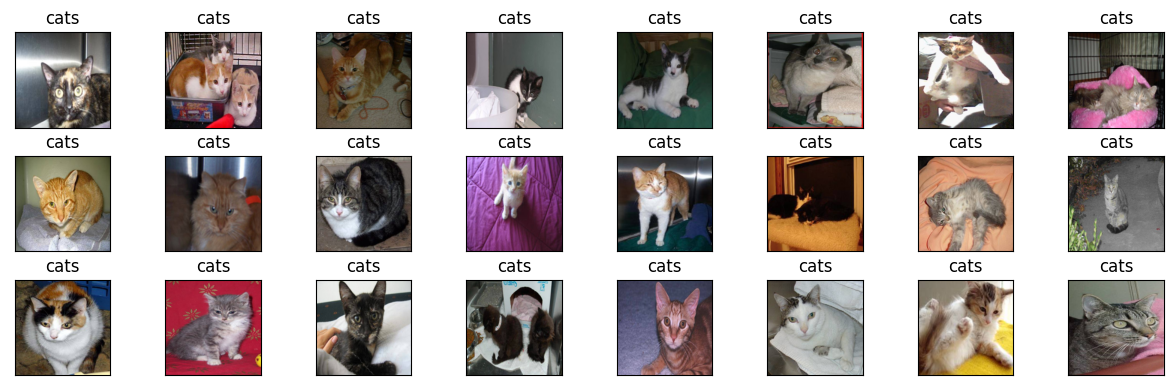

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Class Distribution

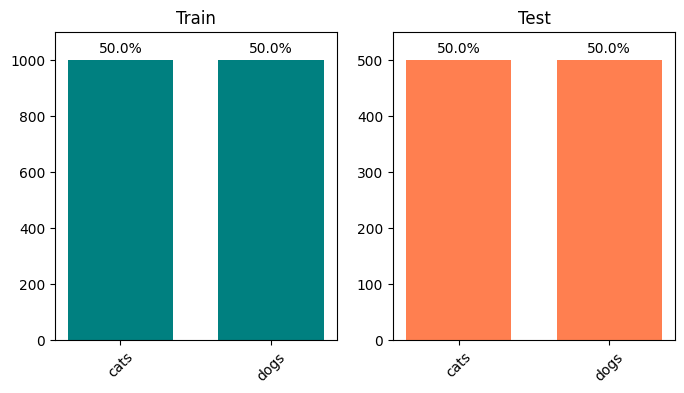

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

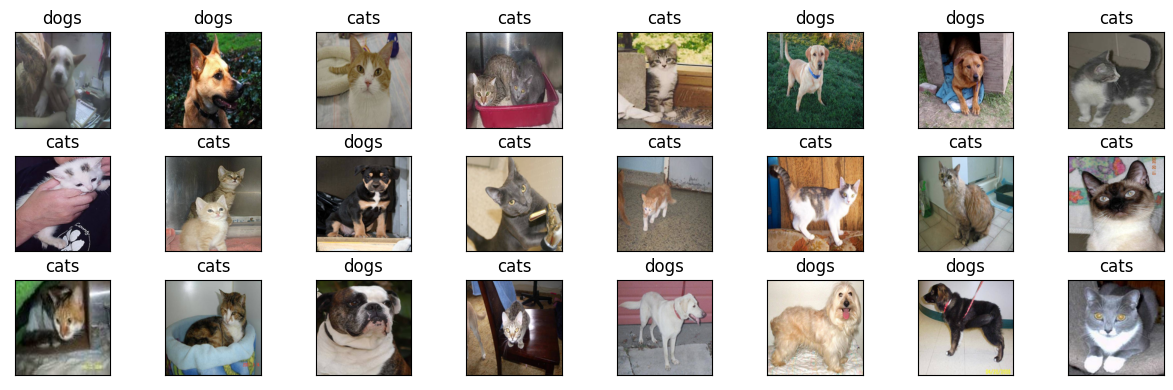

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

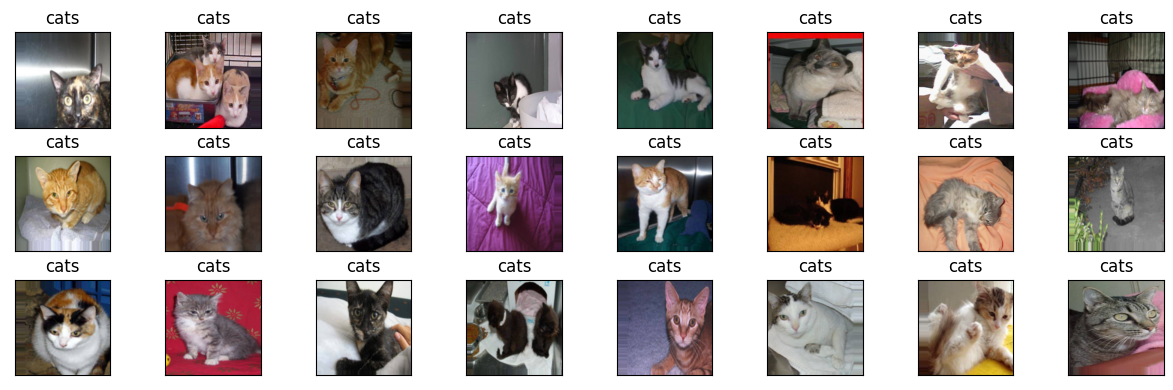

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

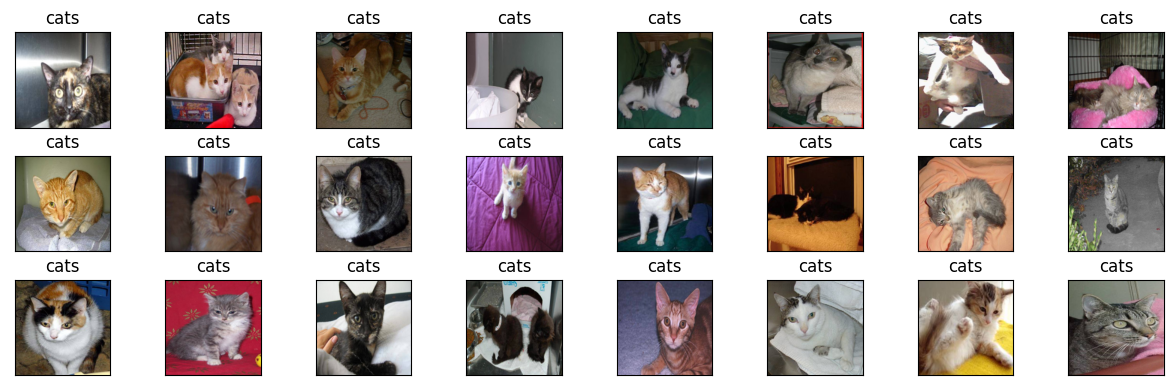

In [20]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [21]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [22]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


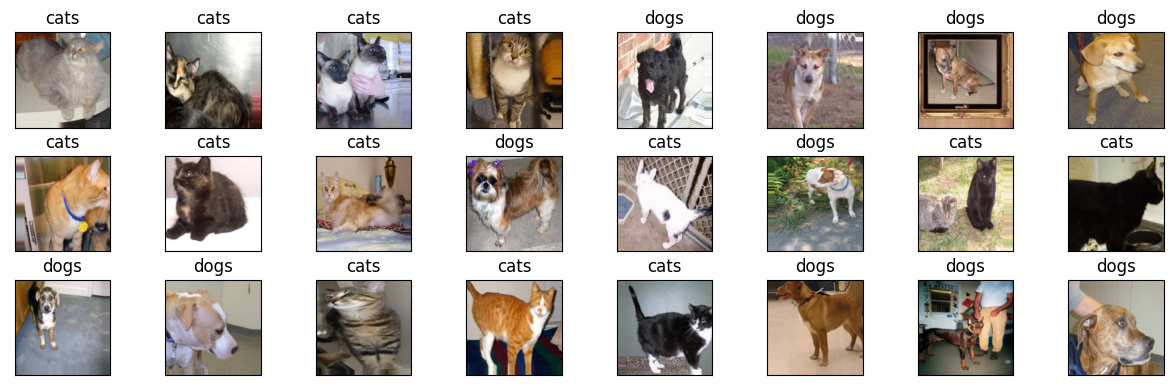

In [23]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-16 03:01:52,248: INFO: model_params.mlp1.dropout=0.1
2022-08-16 03:01:52,249: INFO: model_params.mlp1.layer_count=1
2022-08-16 03:01:52,249: INFO: model_params.mlp1.units=128
2022-08-16 03:01:52,301: INFO: learning_rate=0.001
2022-08-16 03:01:52,302: INFO: model_params.mlp1.clip_value=None
2022-08-16 03:01:52,308: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 76800)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9830528   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9,830,786
Trainable params: 9,830,786
Non-traina

2022-08-16 03:01:52,322: INFO: model_params.mlp1.epochs=20
2022-08-16 03:01:52,323: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1, monitor=val_accuracy)
2022-08-16 03:01:52,324: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-16 03:01:52,324: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 03:01:52,325: INFO: use LearningRateScheduler()
2022-08-16 03:01:52,326: INFO: steps_per_epoch=62
2022-08-16 03:01:52,326: INFO: start training
2022-08-16 03:01:52,327: INFO: use_class_weight=False


Epoch 1/20
57/62 [==========================>...] - ETA: 0s - loss: 10.8342 - accuracy: 0.5186INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:01:54,501: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 2s 29ms/step - loss: 10.4580 - accuracy: 0.5171 - val_loss: 5.7688 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 1s 10ms/step - loss: 4.3955 - accuracy: 0.6099 - val_loss: 5.0520 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 1s 9ms/step - loss: 3.7600 - accuracy: 0.6477 - val_loss: 7.5224 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 1s 9ms/step - loss: 2.8103 - accuracy: 0.6835 - val_loss: 6.6233 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 5/20
57/62 [==========================>...] - ETA: 0s - loss: 2.1039 - accuracy: 0.7111INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:01:57,828: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 2s 26ms/step - loss: 2.0687 - accuracy: 0.7087 - val_loss: 3.7468 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 1s 9ms/step - loss: 1.4771 - accuracy: 0.7490 - val_loss: 3.6363 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 7/20
57/62 [==========================>...] - ETA: 0s - loss: 0.7121 - accuracy: 0.7851INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:01:59,821: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.7166 - accuracy: 0.7863 - val_loss: 3.5138 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 8/20
62/62 [==============================] - 1s 9ms/step - loss: 0.5481 - accuracy: 0.8221 - val_loss: 3.3933 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 9/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4620 - accuracy: 0.8432 - val_loss: 3.4762 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 10/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4557 - accuracy: 0.8443 - val_loss: 5.0886 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 11/20
62/62 [==============================] - 1s 9ms/step - loss: 0.5467 - accuracy: 0.8468 - val_loss: 3.5910 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 12/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4081 - accuracy: 0.8614 - val_loss: 3.7821 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 13/20
57/62 [==========================>...] - ETA: 0s - loss: 0.3160 - accuracy: 0

2022-08-16 03:02:04,027: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.3147 - accuracy: 0.8700 - val_loss: 4.1474 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 14/20
62/62 [==============================] - 1s 9ms/step - loss: 0.3426 - accuracy: 0.8810 - val_loss: 4.5584 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 15/20
62/62 [==============================] - 1s 9ms/step - loss: 0.3710 - accuracy: 0.8790 - val_loss: 3.4793 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 16/20
57/62 [==========================>...] - ETA: 0s - loss: 0.2954 - accuracy: 0.8969INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:02:06,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.2906 - accuracy: 0.8957 - val_loss: 3.8167 - val_accuracy: 0.5790 - lr: 0.0010
Epoch 17/20
62/62 [==============================] - 1s 9ms/step - loss: 0.2620 - accuracy: 0.8916 - val_loss: 5.1387 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 18/20
57/62 [==========================>...] - ETA: 0s - loss: 0.4214 - accuracy: 0.8750INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:02:08,614: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 24ms/step - loss: 0.4386 - accuracy: 0.8745 - val_loss: 3.9615 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 19/20
57/62 [==========================>...] - ETA: 0s - loss: 0.3809 - accuracy: 0.8821INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-16 03:02:10,053: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.3978 - accuracy: 0.8785 - val_loss: 3.9615 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 20/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4088 - accuracy: 0.8775 - val_loss: 4.4550 - val_accuracy: 0.5870 - lr: 0.0010


2022-08-16 03:02:10,637: INFO: finish training [elapsed time: 18.31 seconds]


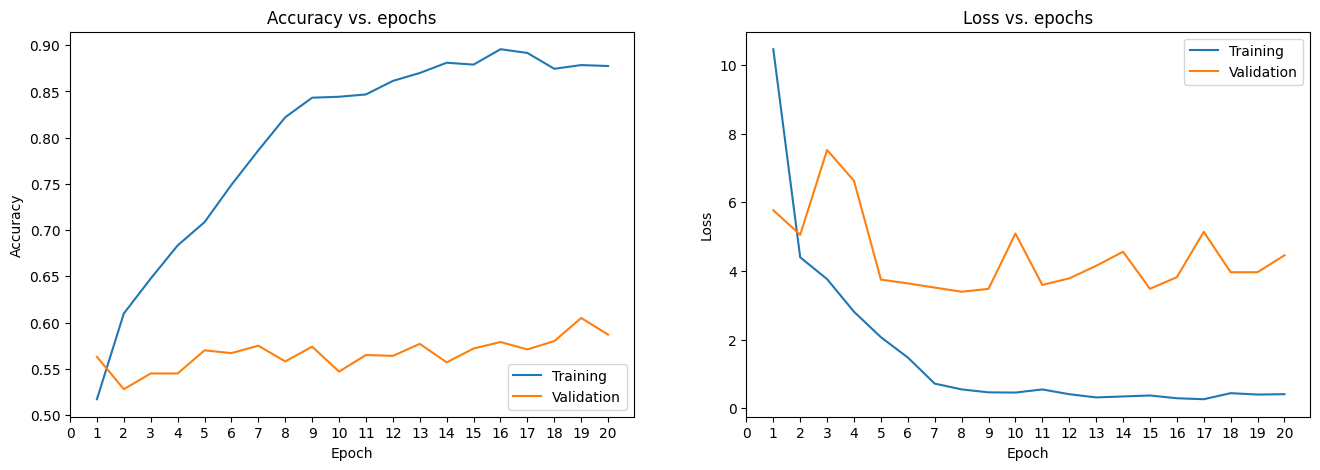

2022-08-16 03:02:11,061: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 0s 5ms/step


2022-08-16 03:02:17,613: INFO: test loss:3.9615
2022-08-16 03:02:17,613: INFO: test accuracy:0.6050
2022-08-16 03:02:17,615: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json
2022-08-16 03:02:17,617: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json
2022-08-16 03:02:17,617: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:02:17,618: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
32/32 [==============================] - 0s 5ms/step


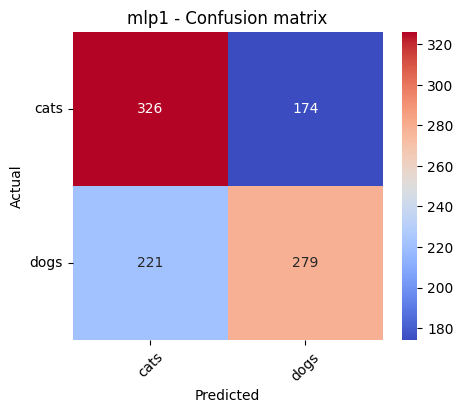

----------------------------------------sample analysis----------------------------------------
1/1 [==============================] - 0s 9ms/step


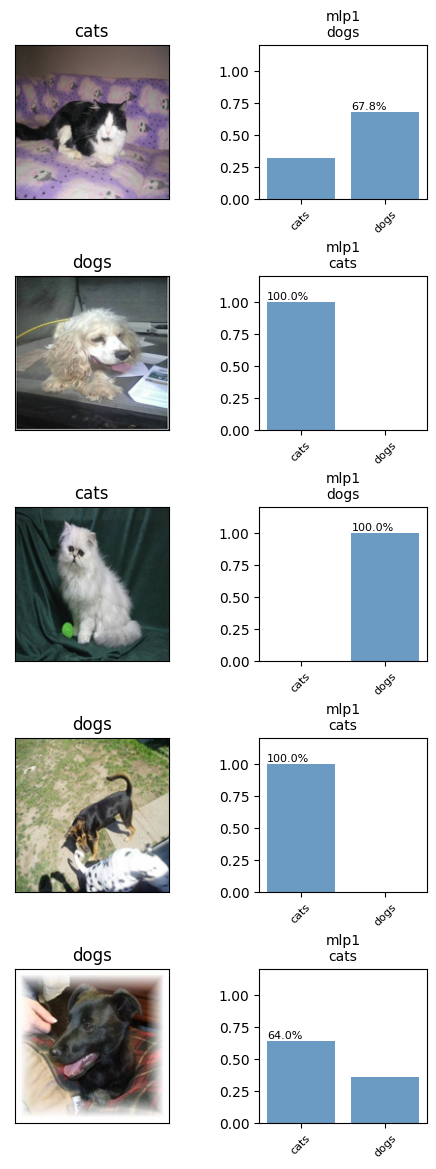

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        18.3   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 03:02      0.2615     3.9615          0.9155          0.605   

   train_auc  test_auc  
1     0.9723    0.6213

In [28]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 03:02:43,981: INFO: model_params.lenet1.dropout=0.2
2022-08-16 03:02:44,102: INFO: learning_rate=0.001
2022-08-16 03:02:44,103: INFO: model_params.lenet1.clip_value=None
2022-08-16 03:02:44,111: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 6)        0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 80, 80, 6)         0    

2022-08-16 03:02:44,152: INFO: model_params.lenet1.epochs=20
2022-08-16 03:02:44,153: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1, monitor=val_accuracy)
2022-08-16 03:02:44,154: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-16 03:02:44,155: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 03:02:44,156: INFO: use LearningRateScheduler()
2022-08-16 03:02:44,157: INFO: steps_per_epoch=62
2022-08-16 03:02:44,158: INFO: start training
2022-08-16 03:02:44,159: INFO: use_class_weight=False


Epoch 1/20
61/62 [============================>.] - ETA: 0s - loss: 1.5417 - accuracy: 0.5364

2022-08-16 03:02:49,121: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:02:49,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 6s 58ms/step - loss: 1.5408 - accuracy: 0.5363 - val_loss: 1.5253 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 2/20
61/62 [============================>.] - ETA: 0s - loss: 1.0272 - accuracy: 0.5676

2022-08-16 03:02:52,149: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:02:52,747: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 1.0216 - accuracy: 0.5696 - val_loss: 2.6715 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 3/20
61/62 [============================>.] - ETA: 0s - loss: 0.7516 - accuracy: 0.5927

2022-08-16 03:02:55,214: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:02:55,820: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.7512 - accuracy: 0.5927 - val_loss: 2.1287 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/20
61/62 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.6578

2022-08-16 03:02:58,082: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:02:58,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 0.6560 - accuracy: 0.6557 - val_loss: 2.1976 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 5/20
61/62 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.6732

2022-08-16 03:03:00,993: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:01,607: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 0.6217 - accuracy: 0.6719 - val_loss: 1.4921 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 1s 17ms/step - loss: 0.5112 - accuracy: 0.7404 - val_loss: 1.6848 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 7/20
61/62 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.7587

2022-08-16 03:03:05,159: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:05,764: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.4894 - accuracy: 0.7571 - val_loss: 1.2646 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 8/20
61/62 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.7961

2022-08-16 03:03:08,014: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:08,604: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 46ms/step - loss: 0.4240 - accuracy: 0.7964 - val_loss: 1.1722 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 9/20
61/62 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8484

2022-08-16 03:03:10,868: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:11,458: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 46ms/step - loss: 0.3484 - accuracy: 0.8478 - val_loss: 0.8837 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 10/20
62/62 [==============================] - 1s 17ms/step - loss: 0.3073 - accuracy: 0.8664 - val_loss: 1.1312 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 11/20
61/62 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9011

2022-08-16 03:03:15,023: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:15,619: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.2339 - accuracy: 0.9017 - val_loss: 0.9254 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 12/20
62/62 [==============================] - 1s 17ms/step - loss: 0.1956 - accuracy: 0.9229 - val_loss: 1.0229 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 13/20
62/62 [==============================] - 1s 17ms/step - loss: 0.2067 - accuracy: 0.9214 - val_loss: 1.3483 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 14/20
62/62 [==============================] - 1s 17ms/step - loss: 0.1296 - accuracy: 0.9481 - val_loss: 1.1684 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 15/20
62/62 [==============================] - 1s 17ms/step - loss: 0.1154 - accuracy: 0.9602 - val_loss: 1.2662 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 16/20
61/62 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9559

2022-08-16 03:03:22,180: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:22,784: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 0.1130 - accuracy: 0.9561 - val_loss: 1.2735 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 17/20
62/62 [==============================] - 1s 17ms/step - loss: 0.0951 - accuracy: 0.9698 - val_loss: 1.4236 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 18/20
62/62 [==============================] - 1s 17ms/step - loss: 0.0653 - accuracy: 0.9773 - val_loss: 1.5873 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 19/20
61/62 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9549

2022-08-16 03:03:27,182: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-16 03:03:27,784: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 47ms/step - loss: 0.1247 - accuracy: 0.9546 - val_loss: 1.4377 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 20/20
62/62 [==============================] - 1s 17ms/step - loss: 0.1081 - accuracy: 0.9592 - val_loss: 1.3360 - val_accuracy: 0.6870 - lr: 0.0010


2022-08-16 03:03:28,915: INFO: finish training [elapsed time: 44.76 seconds]


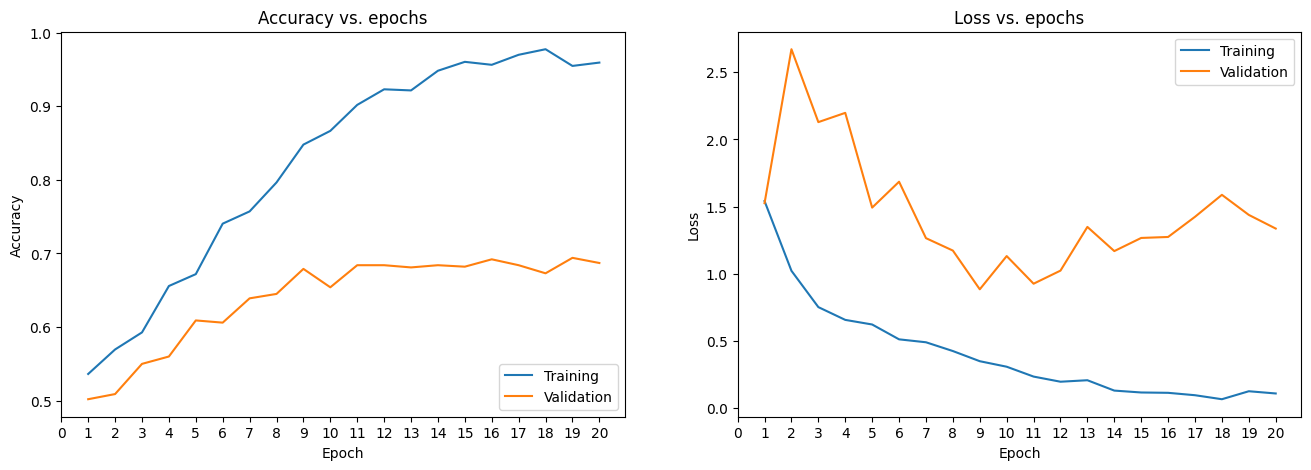

2022-08-16 03:03:29,545: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 6ms/step


2022-08-16 03:03:36,852: INFO: test loss:1.4377
2022-08-16 03:03:36,852: INFO: test accuracy:0.6940
2022-08-16 03:03:36,854: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-16 03:03:36,855: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json
2022-08-16 03:03:36,856: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:03:36,857: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:03:36,858: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1


----------------------------------------confusion matrix----------------------------------------


2022-08-16 03:03:37,258: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 0s 5ms/step


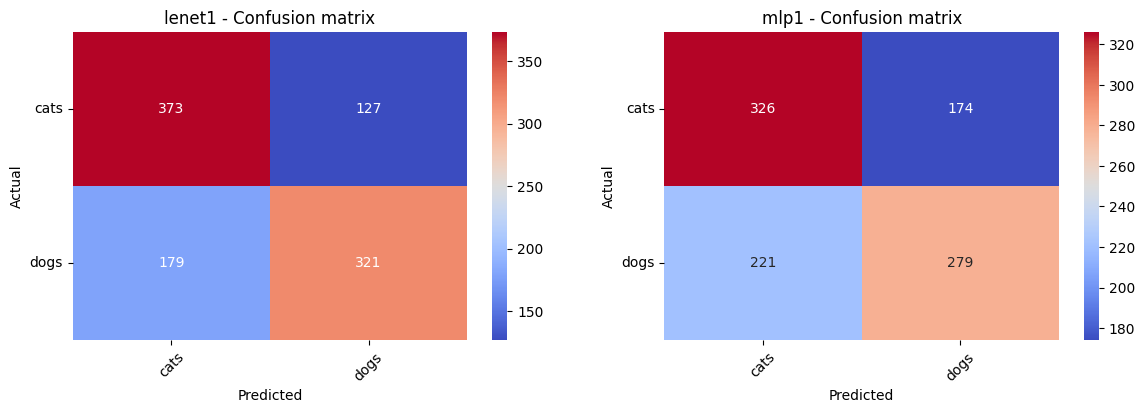

2022-08-16 03:03:39,693: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-16 03:03:40,093: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator


1/1 [==============================] - 0s 8ms/step


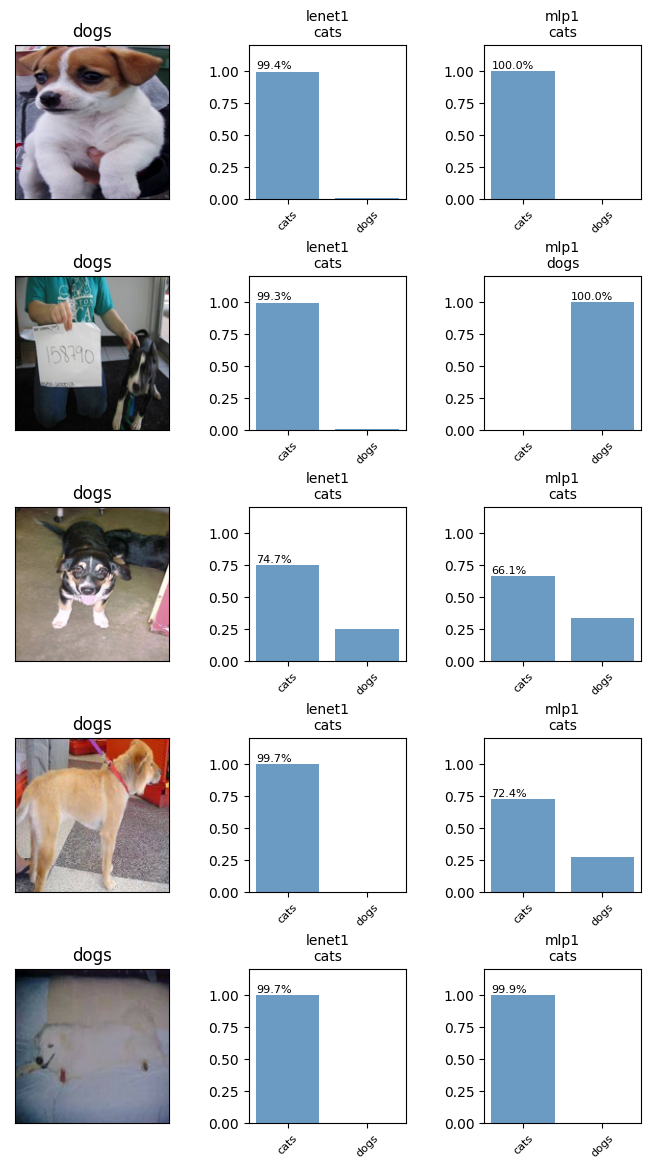

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        44.8   
2       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        18.3   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 03:03      0.0703     1.4377          0.9760          0.694   
2  2022-08-16 03:02      0.2615     3.9615          0.9155          0.605   

   train_auc  test_auc  
1     0.9976    0.7489  
2     0.9723    0.6213

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Custom 1


2022-08-16 03:03:42,617: INFO: model_params.custom1.dropout=0.2
2022-08-16 03:03:42,718: INFO: learning_rate=0.001
2022-08-16 03:03:42,718: INFO: model_params.custom1.clip_value=None
2022-08-16 03:03:42,724: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 80, 80, 32)        0   

2022-08-16 03:03:42,757: INFO: model_params.custom1.epochs=20
2022-08-16 03:03:42,758: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1, monitor=val_accuracy)
2022-08-16 03:03:42,759: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-16 03:03:42,759: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 03:03:42,760: INFO: use LearningRateScheduler()
2022-08-16 03:03:42,761: INFO: steps_per_epoch=62
2022-08-16 03:03:42,761: INFO: start training
2022-08-16 03:03:42,762: INFO: use_class_weight=False


Epoch 1/20
61/62 [============================>.] - ETA: 0s - loss: 1.3302 - accuracy: 0.6014

2022-08-16 03:03:47,915: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:03:48,550: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 6s 80ms/step - loss: 1.3198 - accuracy: 0.6013 - val_loss: 29.1336 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 2s 38ms/step - loss: 0.6484 - accuracy: 0.6169 - val_loss: 23.5832 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 2s 38ms/step - loss: 0.5688 - accuracy: 0.6719 - val_loss: 14.4165 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 2s 38ms/step - loss: 0.5360 - accuracy: 0.7117 - val_loss: 15.9714 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
61/62 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.7249

2022-08-16 03:03:59,348: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:00,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.5044 - accuracy: 0.7238 - val_loss: 6.4846 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 6/20
61/62 [============================>.] - ETA: 0s - loss: 0.5029 - accuracy: 0.7372

2022-08-16 03:04:03,720: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:04,606: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 75ms/step - loss: 0.5034 - accuracy: 0.7359 - val_loss: 2.5482 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 7/20
61/62 [============================>.] - ETA: 0s - loss: 0.4523 - accuracy: 0.7643

2022-08-16 03:04:08,348: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:09,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.4519 - accuracy: 0.7641 - val_loss: 1.1006 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 8/20
61/62 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.7966

2022-08-16 03:04:12,721: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:13,373: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.3984 - accuracy: 0.7969 - val_loss: 1.1556 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 9/20
62/62 [==============================] - 2s 38ms/step - loss: 0.3963 - accuracy: 0.8024 - val_loss: 1.0824 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 10/20
61/62 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8181

2022-08-16 03:04:19,715: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:20,384: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 76ms/step - loss: 0.3761 - accuracy: 0.8170 - val_loss: 0.9522 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 11/20
61/62 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8391

2022-08-16 03:04:24,127: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:24,779: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.3290 - accuracy: 0.8387 - val_loss: 0.9985 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 12/20
61/62 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.8622

2022-08-16 03:04:28,504: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:29,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.2739 - accuracy: 0.8619 - val_loss: 0.8653 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 13/20
61/62 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.8781

2022-08-16 03:04:33,143: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:33,798: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 75ms/step - loss: 0.2486 - accuracy: 0.8785 - val_loss: 0.9753 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 14/20
62/62 [==============================] - 2s 38ms/step - loss: 0.1981 - accuracy: 0.8957 - val_loss: 1.0628 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 15/20
62/62 [==============================] - 2s 38ms/step - loss: 0.1955 - accuracy: 0.9052 - val_loss: 0.8320 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 16/20
61/62 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9175

2022-08-16 03:04:42,248: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:42,907: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 72ms/step - loss: 0.1767 - accuracy: 0.9158 - val_loss: 0.9090 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 17/20
61/62 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9303

2022-08-16 03:04:46,603: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:47,266: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.1565 - accuracy: 0.9299 - val_loss: 0.9637 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 18/20
61/62 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9160

2022-08-16 03:04:51,233: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:51,900: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 75ms/step - loss: 0.1674 - accuracy: 0.9153 - val_loss: 0.9990 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 19/20
61/62 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9273

2022-08-16 03:04:55,628: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:04:56,299: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 4s 72ms/step - loss: 0.1572 - accuracy: 0.9279 - val_loss: 0.9348 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 20/20
61/62 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9329

2022-08-16 03:05:00,247: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


2022-08-16 03:05:00,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 75ms/step - loss: 0.1428 - accuracy: 0.9325 - val_loss: 1.0131 - val_accuracy: 0.7330 - lr: 0.0010


2022-08-16 03:05:00,998: INFO: finish training [elapsed time: 78.24 seconds]


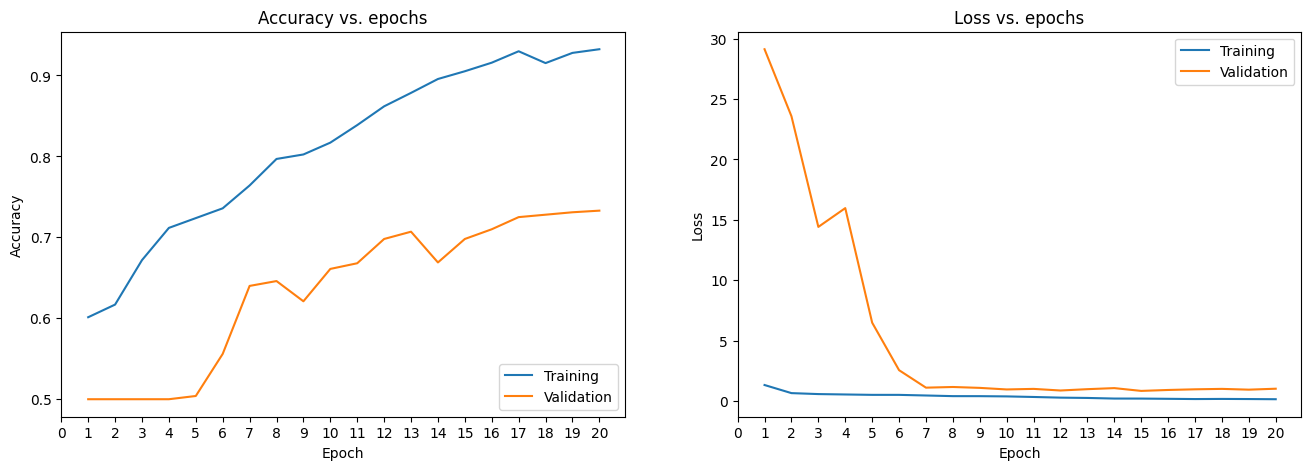

2022-08-16 03:05:01,415: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/custom1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 9ms/step


2022-08-16 03:05:09,563: INFO: test loss:1.0131
2022-08-16 03:05:09,563: INFO: test accuracy:0.7330
2022-08-16 03:05:09,565: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json
2022-08-16 03:05:09,566: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/results.json
2022-08-16 03:05:09,567: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:05:09,568: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:05:09,569: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 03:05:10,390: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 1s 6ms/step


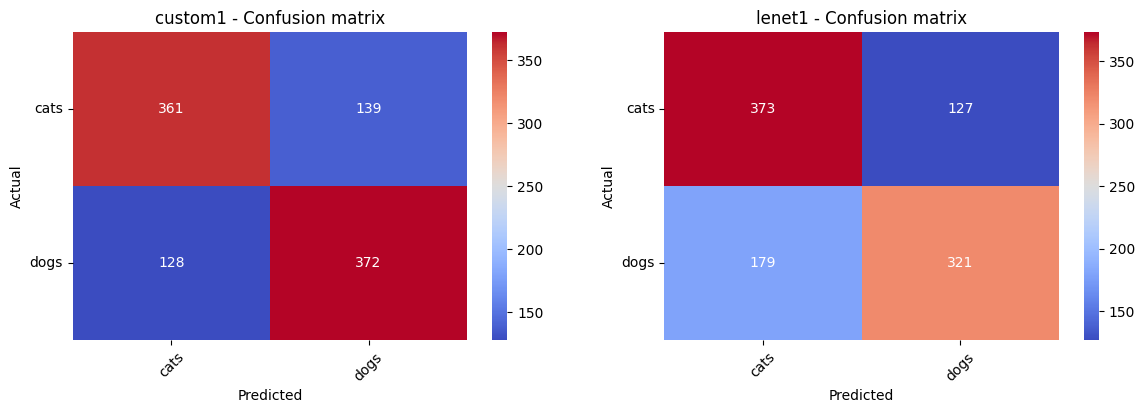

2022-08-16 03:05:13,010: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-16 03:05:13,826: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator
2022-08-16 03:05:13,827: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/mlp1
2022-08-16 03:05:14,570: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/default.generator


1/1 [==============================] - 0s 8ms/step


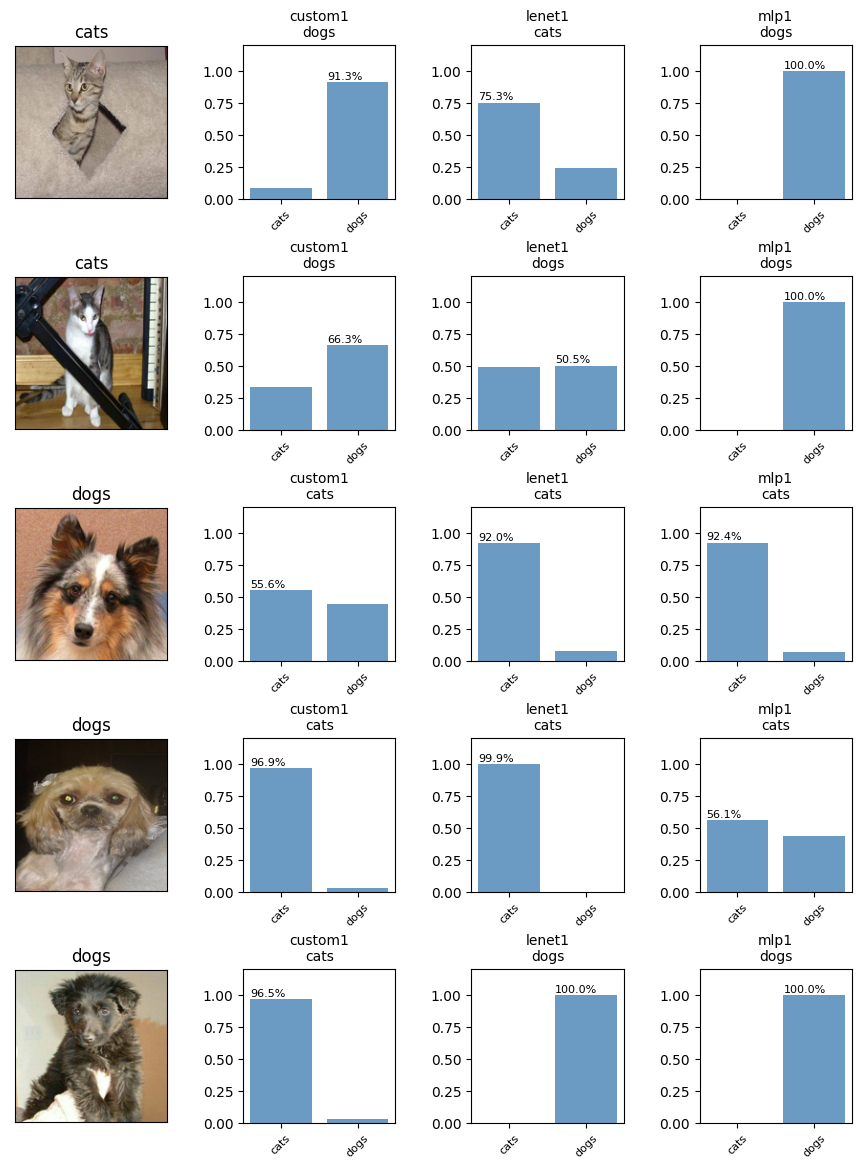

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_1000.ipynb        1383938        78.2   
2     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        44.8   
3       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        18.3   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 03:05      0.0501     1.0131          0.9790          0.733   
2  2022-08-16 03:03      0.0703     1.4377          0.9760          0.694   
3  2022-08-16 03:02      0.2615     3.9615          0.9155          0.605   

   train_auc  test_auc  
1     0.9982    0.8140  
2     0.9976    0.7489  
3     0.9723    0.6213

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2022-08-16 03:07:15,394: INFO: model_params.vgg8.dropout=0.4
2022-08-16 03:07:15,588: INFO: learning_rate=0.001
2022-08-16 03:07:15,589: INFO: model_params.vgg8.clip_value=None
2022-08-16 03:07:15,597: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_con1 (Conv2D)        (None, 160, 160, 64)      1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 160, 160, 64)     256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 160, 160, 64)      0         
                                                                 
 block1_con2 (Conv2D)        (None, 160, 160, 64)      36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 160, 160, 64)     256       
 ion)                                                         

2022-08-16 03:07:15,650: INFO: model_params.vgg8.epochs=20
2022-08-16 03:07:15,650: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8, monitor=val_accuracy)
2022-08-16 03:07:15,651: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-16 03:07:15,652: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 03:07:15,652: INFO: use LearningRateScheduler()
2022-08-16 03:07:15,653: INFO: steps_per_epoch=62
2022-08-16 03:07:15,654: INFO: start training
2022-08-16 03:07:15,654: INFO: use_class_weight=False


Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 8.6082 - accuracy: 0.5121

2022-08-16 03:07:30,222: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-16 03:07:31,569: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 16s 239ms/step - loss: 8.6082 - accuracy: 0.5121 - val_loss: 30.7157 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.9182 - accuracy: 0.5292

2022-08-16 03:07:45,061: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-16 03:07:46,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 15s 241ms/step - loss: 0.9182 - accuracy: 0.5292 - val_loss: 0.7541 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5257

2022-08-16 03:07:59,584: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-16 03:08:00,932: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 15s 235ms/step - loss: 0.6885 - accuracy: 0.5257 - val_loss: 0.7104 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.5202

2022-08-16 03:08:14,138: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-16 03:08:15,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 15s 236ms/step - loss: 0.6832 - accuracy: 0.5202 - val_loss: 0.7296 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 5/20
12/62 [====>.........................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5495

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Pretrained Model + Fune-Tune

In [ ]:
input_shape = [32, 32, 3]

def resize(shape):
    def resize_(x):
        return tf.image.resize(x, shape)
    return resize_

In [ ]:
preprocess_fun = [resize(input_shape[:-1]), rescale]

In [ ]:
sample_images[0]

In [ ]:
sample_images1 = resize(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

#### MobileNet V2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

In [ ]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    helper.compile(model)
    return model 

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)

In [ ]:
# model = fine_tuning(helper, model, base)
# history = helper.train(model)

In [ ]:
helper.model_summary(model, history, show_sample_analysis=True) 

## Evaluation

### Best Model

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)